<a href="https://colab.research.google.com/github/umesh70/Stable-Diffusion/blob/main/ImagePipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Generation and Background Replacement using Stable Diffusion**

## Notebook Content

- Install Required Libraries
- Environment Setup
- Import necessary Files
- Load Quantized model
- Text-to-Image model Inference
- Image-to-ImageInference
- Inpainting and replacing background with mask

In [1]:
# Install required libraries
!pip install diffusers transformers accelerate torch
!pip install -q diffusers transformers torch accelerate
!pip install -U bitsandbytes
!pip install -q opencv-python-headless
!pip install -q xformers
!pip install DeepCache
!pip install triton
!pip install --upgrade diffusers
!pip install ipyplot
!pip install -U rembg
!pip install onnxruntime
!pip install cv2
!pip install segment-anything
!wget https://i.pinimg.com/736x/43/19/1b/43191b40206dad98132d8617b2a8ccb5.jpg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
--2024-12-22 16:21:22--  https://i.pinimg.com/736x/43/19/1b/43191b40206dad9813

In [2]:
# Environment setup
from google.colab import userdata
from huggingface_hub import login
import bitsandbytes
import os
login(userdata.get('HF_TOKEN'))
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [10]:
# Import necessary files
import torch
from diffusers import AutoencoderTiny
from diffusers import StableDiffusion3Pipeline,DiffusionPipeline, StableDiffusionImg2ImgPipeline, UNet2DConditionModel
from xformers.ops import MemoryEfficientAttentionFlashAttentionOp
from transformers import T5EncoderModel,AutoFeatureExtractor,CLIPTextModel
from transformers import BitsAndBytesConfig
import ipyplot
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from diffusers import StableDiffusionImg2ImgPipeline,StableDiffusionInpaintPipeline
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from diffusers import SD3Transformer2DModel
from rembg import remove


# Load Quantized model

In [4]:
# Quantization parameters, optimized for 'nf4'

def quantizedparams():

  quantizationConfig = BitsAndBytesConfig(
      load_in_4bit=True,
      bnb_4bit_quant_type="nf4",
      bnb_4bit_compute_dtype=torch.float16,
      bnb_4bit_use_double_quant=True,
  )
  return quantizationConfig

In [5]:
# Define torch compiler parameters to speed up the inference by as much as 4X
torch.set_float32_matmul_precision('high')
torch._inductor.config.conv_1x1_as_mm = True
torch._inductor.config.coordinate_descent_tuning = True
torch._inductor.config.epilogue_fusion = False
torch._inductor.config.coordinate_descent_check_all_directions = True
torch._inductor.config.force_fuse_int_mm_with_mul = True
torch._inductor.config.use_mixed_mm = True


# Define TinyAutoEncoder for stable Diffusion 3 to decode StableDiffusion3Pipeline optimally
TinyVae = AutoencoderTiny.from_pretrained("madebyollin/taesd3", torch_dtype=torch.float16).to("cuda")


config.json:   0%|          | 0.00/637 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/9.85M [00:00<?, ?B/s]

The config attributes {'block_out_channels': [64, 64, 64, 64]} were passed to AutoencoderTiny, but are not expected and will be ignored. Please verify your config.json configuration file.


# Text-to-Image model inference


In [ ]:
"""
'modelinference' function is a general function which returns image based on the arguments.
"""
"""
Stable Diffusion 3 model is a culmination of several models:
  -Transformer(MMDit)
  -Scheduler
  -Variational Auto-Encoder
  -3 text encoders, from which T5 encoder is the largest
  -3 text tokenizers

To load a quantized stable diffusion model, we can either quantize the T5 encoder or the transformer model by loading the file checkpoint.

For instance below is the example of loading a stable diffusion 3 model by quantizing the T5 encoder.
Even then the inference is quite time consuming.
"""

def modelInference(modelID,prompt, image = None):

  # text encoder for model inference
  textEncoder = T5EncoderModel.from_pretrained(
      modelID,
      subfolder="text_encoder_3",
      quantization_config=quantizedparams(),
      trust_remote_code=True,
      torch_dtype=torch.float16,
  )

  generator = torch.Generator(device="cuda").manual_seed(1)
  # define a pipeline for text-to-image model inference
  modelPipeline = StableDiffusion3Pipeline.from_pretrained(
        modelID,
        text_encoder_3=textEncoder,
        vae=TinyVae,
        device_map="balanced",
        torch_dtype=torch.float16,
    )

  # Use adapters for faster inference and better results
  modelPipeline.load_lora_weights("nerijs/pixel-art-xl", weight_name="pixel-art-xl.safetensors", adapter_name="pixel")

  # run inference and return the image
  getImage = modelPipeline(
      prompt=prompt,
      num_inference_steps=20,
      height=512,
      width=512,
      guidance_scale=7.5,
      generator=generator,
  ).images[0]

  return getImage, modelPipeline


In [ ]:
# pass modelId and prompt to get image output
modelId = "stabilityai/stable-diffusion-3-medium-diffusers"
prompt1="A small cabin on top of a snowy mountain in the style of Disney, pixel art"

In [ ]:
imageGen,modelPipeline = modelInference(modelId,prompt1)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


text_encoder_3/config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


(…)t_encoder_3/model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/247M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

tokenizer_3/special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer_3/tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_3/tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

transformer/config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.17G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


pixel-art-xl.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# prompt2 = "A small cabin on top of a snowy mountain in the style of Disney, artstation,pixel art"
# image = modelPipeline(
#     prompt2, num_inference_steps=100,generator=torch.manual_seed(0),
#     height=512,
#     width=512
# ).images[0]


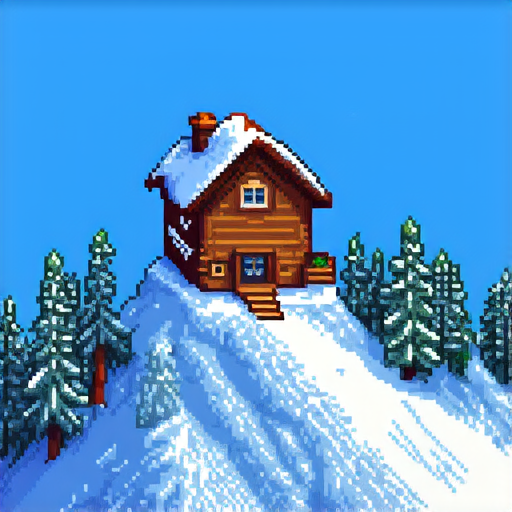


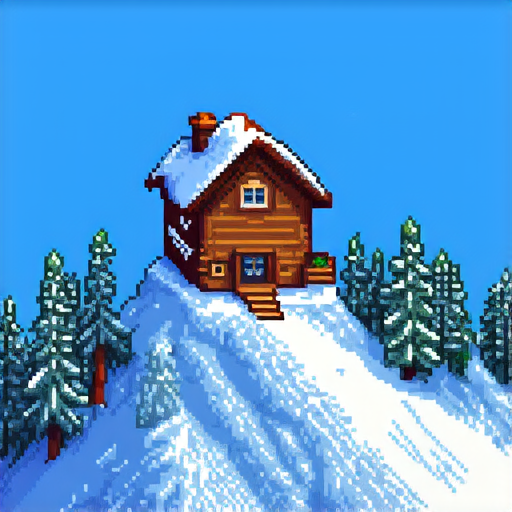

In [ ]:
# Comparison of images generated with and without the Adaptor

# Convert images to NumPy arrays with dtype uint8
images = [np.array(img.convert('RGB'), dtype=np.uint8) for img in [imageGen]]

labels = ["Image with Adapter"]
ipyplot.plot_images(images, labels, img_width = 350)

# Image-to-Image Model

## Use stable diffusion-v1-5 for Image-to-Image inference


In [ ]:
def imageModelInference(modelId, prompt, image):

    modelPipeline= StableDiffusionImg2ImgPipeline.from_pretrained(
    modelId,
    device_map="balanced",
    torch_dtype=torch.float16,
    )

    # modelPipeline.load_lora_weights("nerijs/pixel-art-xl", weight_name="pixel-art-xl.safetensors", adapter_name="pixel")

    genImg = modelPipeline(
        prompt=prompt,
        image=image,
        num_inference_steps=20,
        height=512,
        width=512,
        guidance_scale=7.5,
    ).images[0]

    return genImg,modelPipeline

url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((768, 512))

prompt = "A fantasy landscape, trending on artstation"
modelId = "runwayml/stable-diffusion-v1-5"

In [ ]:
getImage,modelPipeline = imageModelInference(modelId,prompt,init_image)

Keyword arguments {'load_4bit': True, 'bnb_4bit_quant_type': 'nf4'} are not expected by StableDiffusionImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Taking `'Attention' object has no attribute 'key'` while using `accelerate.load_checkpoint_and_dispatch` to mean /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/608a7bbe4e4a6a66513c80999e32708671fd2ac0/vae was saved with deprecated attention block weight names. We will load it with the deprecated attention block names and convert them on the fly to the new attention block format. Please re-save the model after this conversion, so we don't have to do the on the fly renaming in the future. If the model is from a hub checkpoint, please also re-upload it or open a PR on the original repository.


  0%|          | 0/16 [00:00<?, ?it/s]


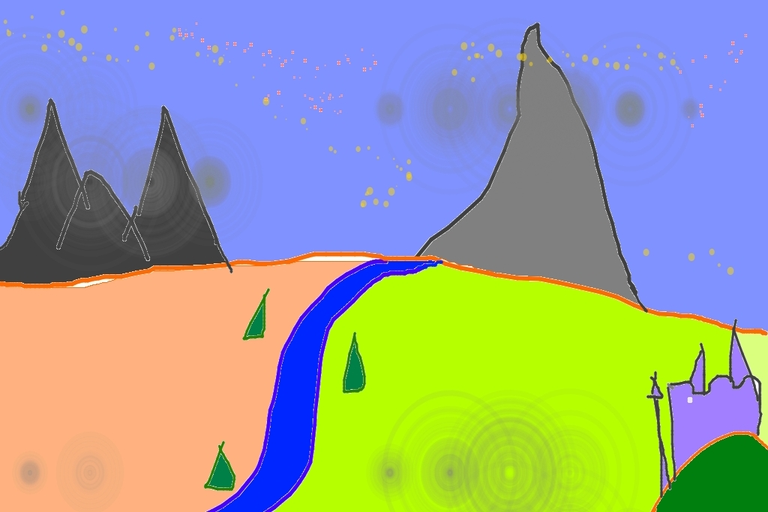
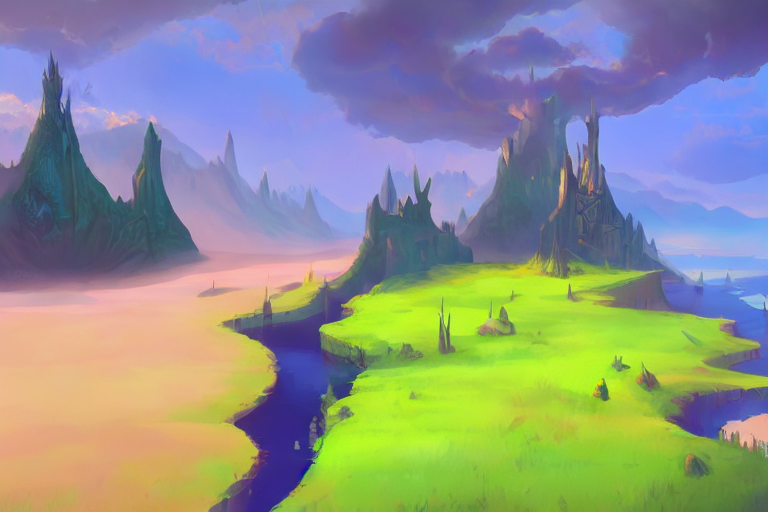


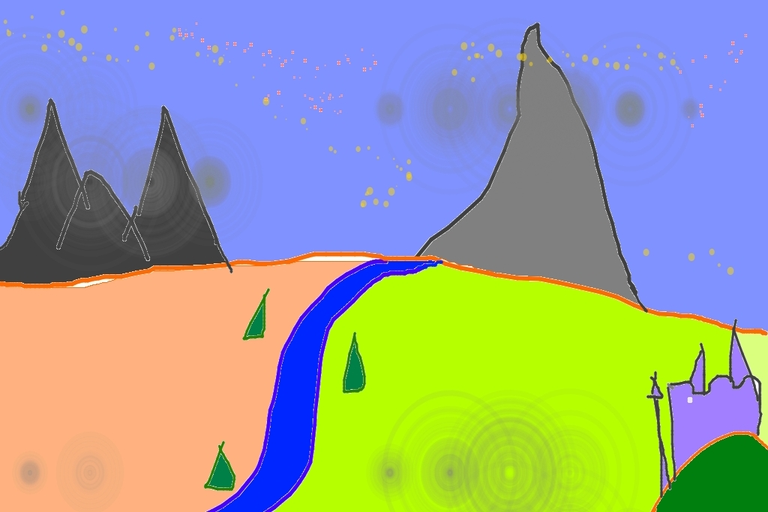
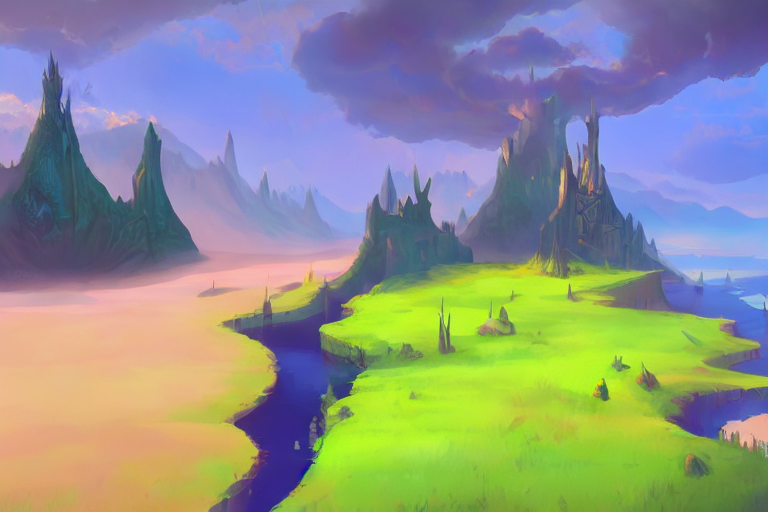

In [ ]:
# Convert images to NumPy arrays with dtype uint8
images = [np.array(img.convert('RGB'), dtype=np.uint8) for img in [init_image,getImage]]

labels = ["Initial image", "Generated image"]
ipyplot.plot_images(images, labels, img_width = 350)

# Inpainting and replacing background with mask

In [32]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def maskRender(image):
  output = remove(image)

  outputArray = np.array(output)
  mask = (outputArray[:,:,3] > 0).astype(np.uint8)
  mask = 1-mask


  maskDisplay = outputArray *255

  maskResult = np.array(image.copy())
  maskResult[mask==1] =[255, 255, 255]
  maskResult[mask!=1] =[0, 0, 0]
  maskResult = Image.fromarray(maskResult)

  return maskDisplay, maskResult

def loadModel():
  pipe = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting",
        revision="fp16",
        torch_dtype=torch.float16,).to("cuda")
  return pipe

def replaceBackground(image,prompt,replacementPrompt):
  pipe = loadModel()
  maskDisplay, maskResult = maskRender(image)
  image = pipe(prompt=prompt,
               image=image, mask_image=maskResult,
               replacement_prompt=replacementPrompt,
               guidance_scale = 7.5,
               num_inference_steps = 50).images[0]
  return image,maskResult

def displayResult(originalImage,mask, resultImage):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(originalImage)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Generated Mask")
    axes[1].axis("off")

    axes[2].imshow(resultImage)
    axes[2].set_title("Result")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

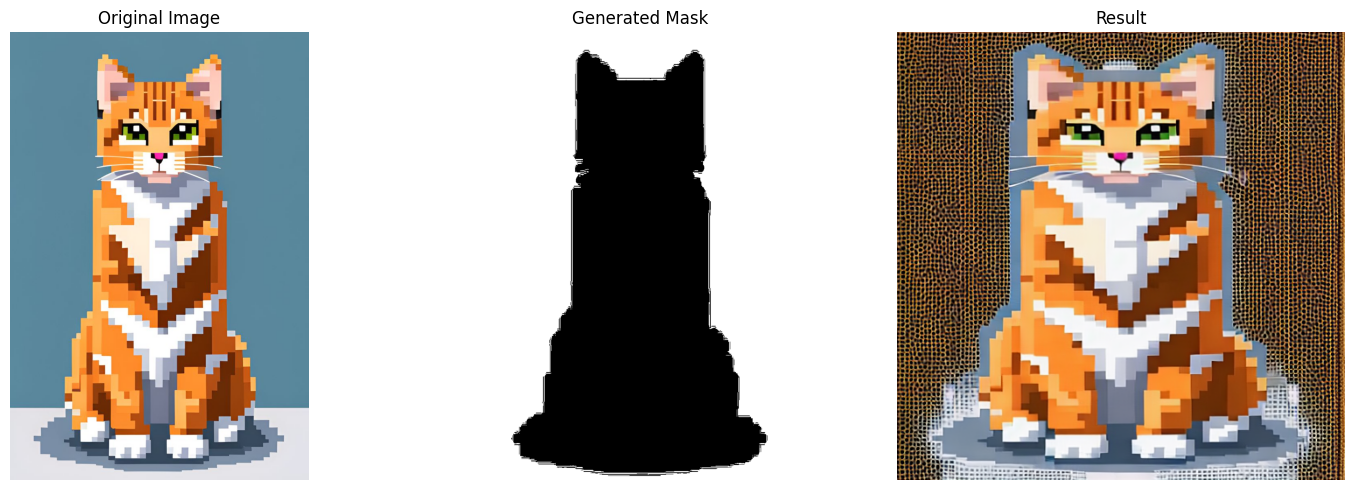

In [34]:
imageGen = Image.open("43191b40206dad98132d8617b2a8ccb5.jpg")
image,maskDisplay = replaceBackground(imageGen,"a pixeled cat", "a pixeled cat in garden filled with flowers")
displayResult(imageGen, maskDisplay, image)
